# **Human-In-The-Loop Multi-Agent Research Workflow**

Demonstrates use of the smolagents library, specifically showing how to implement Human-in-the-Loop strategies to:


*   Interrupt agent execution after plan creation using step callbacks
*   Allow user interaction to review and modify plans (Human-in-the-Loop)
*   Resume execution while preserving agent memory
*  Modify plans in real-time based on user feedback, keeping the human in control

###  **Human-in-the-Loop Workflow**

1. **Agent receives a complex task** – User submits a high-level request.
2. **Plan is auto-generated** – PlannerAgent creates a step-by-step execution plan.
3. **Execution pauses** – A callback stops the workflow for human approval.
4. **User reviews the plan** – Plan is displayed in a clean, formatted layout.
5. **User approves/modifies/cancels** – Human chooses how the agent should proceed.
6. **User edits the plan if needed** – Modified plan replaces the original.
7. **Execution resumes** – Agents continue with the approved or updated plan.
8. **Memory is preserved** – All steps are stored for transparency and future runs.



**Importing And Installing Necessary Library**

In [1]:
!pip install -q langgraph langchain-google-genai


In [2]:
# Installation
! pip install smolagents

In [4]:
import os, json, asyncio
from getpass import getpass
from typing import TypedDict, List, Dict, Any

# LangGraph & LangChain
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass("GOOGLE_API_KEY: ")

GOOGLE_API_KEY: ··········


In [5]:
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass("TAVILY_API_KEY: ")

TAVILY_API_KEY: ··········


**Types & Memory helpers**

In [6]:
MEMORY_FILE = "agent_memory.json"

class AgentState(TypedDict):
    task: str
    plan: str
    approved: bool
    result: str
    history: List[Dict[str, Any]]  # memory entries: {"agent":..., "type":..., "content":...}

def load_memory() -> List[Dict[str, Any]]:
    if os.path.exists(MEMORY_FILE):
        try:
            with open(MEMORY_FILE, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return []
    return []

def save_memory(history: List[Dict[str, Any]]):
    with open(MEMORY_FILE, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=2)

def add_memory_entry(state: AgentState, agent_name: str, entry_type: str, content: str):
    entry = {"agent": agent_name, "type": entry_type, "content": content}
    state["history"].append(entry)
    save_memory(state["history"])

In [7]:
pip install crewai-tools

In [8]:
!pip install crewai_tools tavily-python

  Using cached tavily_python-0.7.14-py3-none-any.whl.metadata (9.0 kB)


**LLM and Tools**

In [17]:
from crewai_tools import TavilySearchTool
llm =ChatGoogleGenerativeAI(model="gemini-2.5-flash")
search_tool = TavilySearchTool(api_key=os.environ["TAVILY_API_KEY"])

**Node: Create Plan**

In [10]:
async def create_plan(state: AgentState):
    print("\n Creating plan using LLM...")
    prompt = f"Create a clear step-by-step plan to accomplish this task:\n\nTASK:\n{state['task']}\n\nReturn numbered steps."
    resp = await llm.ainvoke(prompt)
    plan_text = resp.content.strip()
    # store plan into memory
    add_memory_entry(state, "PlannerAgent", "plan", plan_text)
    return {"plan": plan_text, "approved": False}

**Node: Human Review (approve/modify/cancel)**

In [11]:
async def human_review(state: AgentState):
    print("\n" + "="*70)
    print("🛑 PLAN (needs your approval)")
    print(state["plan"])
    print("="*70)
    while True:
        choice = input("\nChoose: [1] Approve   [2] Modify   [3] Cancel  -> ").strip()
        if choice in ("1", "2", "3"):
            break
        print("Enter 1, 2, or 3.")
    if choice == "1":
        print("✅ Approved.")
        return {"approved": True}
    if choice == "2":
        print("\n✏️ Enter modified plan. End with empty line.")
        lines = []
        while True:
            line = input()
            if line == "":
                break
            lines.append(line)
        new_plan = "\n".join(lines).strip()
        if not new_plan:
            new_plan = state["plan"]
        add_memory_entry(state, "Human", "modified_plan", new_plan)
        print("\n✅ Modified plan saved.")
        return {"plan": new_plan, "approved": True}
    # cancel
    print("❌ Cancelled by user.")
    add_memory_entry(state, "Human", "cancel", "User cancelled execution.")
    return {"result": "cancelled"}

**Node: ResearchAgent (multi-agent step)**

In [20]:
def research_agent(step, memory):
    # Always search using the main task, NOT the plan step text
    query = f"Top AI breakthroughs 2024"
    print(f"Using Tool: Tavily Search -> {query}")
    result = search_tool.search(query=query)
    memory.append({"step": step, "query": query, "result": result})
    return result


**Node: SynthesisAgent**(Read memory (research results) and produce final answer)

In [13]:
async def synthesis_agent(state: AgentState):
    print("\n🧩 SynthesisAgent: synthesizing final result from memory...")
    # collect research entries from state.history
    research_entries = [h for h in state["history"] if h["agent"] == "ResearchAgent" and h["type"] == "search_result"]
    if not research_entries:
        # nothing written—ask LLM to answer from plan only
        prompt = f"Using only the plan and your knowledge, produce a concise answer for the task:\n\nTASK:\n{state['task']}\n\nPLAN:\n{state['plan']}\n"
        resp = await llm.ainvoke(prompt)
        final = resp.content.strip()
        add_memory_entry(state, "SynthesisAgent", "synthesis", final)
        return {"result": final}
    # build context using the top N research entries
    context_texts = [e["content"] for e in research_entries[-6:]]  # take last 6 research entries
    context = "\n\n".join(context_texts)
    prompt = f"""You are the SynthesisAgent. Using ONLY the research results below and the plan, write a concise, referenced final answer to the TASK.

TASK:
{state['task']}

PLAN:
{state['plan']}

RESEARCH RESULTS:
{context}

Write:
- a short summary (3-6 sentences)
- list top 3 breakthroughs (if the task requests that)
- give the source/reference lines (from the research results)
"""
    resp = await llm.ainvoke(prompt)
    final = resp.content.strip()
    add_memory_entry(state, "SynthesisAgent", "synthesis", final)
    return {"result": final}

**Build LangGraph workflow with multi-agent nodes**

In [14]:
graph = StateGraph(AgentState)

graph.add_node("plan", create_plan)
graph.add_node("human", human_review)
graph.add_node("research", research_agent)
graph.add_node("synthesis", synthesis_agent)

graph.set_entry_point("plan")
graph.add_edge("plan", "human")

# routing after human: if cancelled -> END, else research
def routing_after_human(state):
    if state.get("result") == "cancelled":
        return END
    return "research"

graph.add_conditional_edges("human", routing_after_human, {"research": "research", END: END})

graph.add_edge("research", "synthesis")
graph.add_edge("synthesis", END)

app = graph.compile()

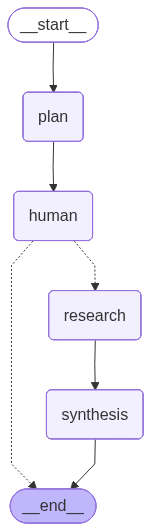

In [39]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

**Runner & resume logic**

In [15]:
async def run_agent(task: str, resume: bool = False):
    # initial_state tries to load previous memory if resume=True
    history = load_memory() if resume else []
    initial_state: AgentState = {
        "task": task,
        "plan": "",
        "approved": False,
        "result": "",
        "history": history
    }
    final = await app.ainvoke(initial_state)
    print("\n🎉 FINAL RESULT")
    print("="*80)
    print(final.get("result", "No final result"))
    print("="*80)
    print(f"\n🔖 Memory entries saved: {len(initial_state['history'])}")
    print("Saved to", MEMORY_FILE)

**Example usage**

In [21]:
import nest_asyncio
nest_asyncio.apply()

task_text = (
    "Search for the top 3 breakthroughs in artificial intelligence in 2024 "
    "and provide a short summary and source lines for each."
)

# Run agent
await run_agent(task_text, resume=False)

# To resume later:
# await run_agent(task_text, resume=True)



 Creating plan using LLM...

🛑 PLAN (needs your approval)
Here is a clear step-by-step plan to accomplish the task:

1.  **Define Search Scope & Keywords:**
    *   Understand that "breakthroughs" imply significant advancements, not minor updates.
    *   Prepare initial search terms such as: "AI breakthroughs 2024," "top AI advancements 2024," "major AI developments 2024," "AI milestones 2024," "impactful AI research 2024."

2.  **Identify Reliable Information Sources:**
    *   Prioritize reputable technology news outlets (e.g., TechCrunch, The Verge, Wired, MIT Technology Review), AI research blogs from major companies (e.g., Google AI, OpenAI, Anthropic), academic news sections, and industry analysis reports. Avoid forums or unverified blogs as primary sources.

3.  **Execute Initial Searches:**
    *   Use your chosen search engine (e.g., Google, Bing) with the keywords identified in Step 1.
    *   Focus on results published or significantly updated *in* 2024. Be mindful that 20